Initial Revert Extraction
===

TODO update me


In [1]:
import mwapi
import mwxml
import mwxml.utilities
import mwcli
import mwreverts
import oresapi
import mwparserfromhell

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
import os
from tqdm import tqdm
import bz2
import json
import re
import hashlib
from datetime import datetime

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [5]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [6]:
ns0_filenames_path = os.path.join(raw_data_dir, "enwiki-20200101-all-titles-in-ns0")
ns0_filenames = open(ns0_filenames_path).readlines()
len(ns0_filenames)

14975823

In [7]:
article_index_path = os.path.join(raw_data_dir, "enwiki-20200101-pages-articles-multistream-index.txt")
article_index = open(article_index_path).readlines()
len(article_index)

19881980

In [59]:
page_title_dict = {}
for line in tqdm(article_index):
    tokens = line.strip().split(":")
    #page_start_bytes = int(tokens[0])
    page_id = int(tokens[1])
    page_title = "".join(tokens[2:])
    page_title_dict[page_id] = page_title
len(page_title_dict)

100%|██████████| 19881980/19881980 [00:34<00:00, 569899.85it/s]


19881980

In [8]:
# this is one of approximately 100 files containing full revision history
dump_filepath = os.path.join(raw_data_dir, "enwiki-20200101-pages-meta-history1.xml-p10p1036.bz2")

In [6]:
# this is the article multistream
# which contains only the most recent revision
dump_filepath = os.path.join(raw_data_dir, "enwiki-20191020-pages-articles-multistream.xml.bz2")

In [9]:
dump = mwxml.Dump.from_file(bz2.open(dump_filepath, 'rt'))
for page in dump:
    print(type(page))
    for revision in page:
        print(type(revision))
        print(revision)
        print(revision.to_json())
        break
    break

<class 'mwxml.iteration.page.Page'>
<class 'mwxml.iteration.revision.Revision'>
Revision(id=233192, timestamp=Timestamp('2001-01-21T02:12:21Z'), user=User(id=99, text='RoseParks'), page=Page(id=10, title='AccessibleComputing', namespace=0, redirect='Computer accessibility', restrictions=[]), minor=False, comment='*', text='This subject covers\n\n* AssistiveTechnology\n\n* AccessibleSoftware\n\n* AccessibleWeb\n\n* LegalIssuesInAccessibleComputing\n\n', bytes=None, sha1='8kul9tlwjm9oxgvqzbwuegt9b2830vw', parent_id=None, model='wikitext', format='text/x-wiki', deleted=Deleted(text=False, comment=False, user=False, restricted=None))
{'id': 233192, 'timestamp': '2001-01-21T02:12:21Z', 'user': {'id': 99, 'text': 'RoseParks'}, 'page': {'id': 10, 'title': 'AccessibleComputing', 'namespace': 0, 'redirect': 'Computer accessibility', 'restrictions': []}, 'minor': False, 'comment': '*', 'text': 'This subject covers\n\n* AssistiveTechnology\n\n* AccessibleSoftware\n\n* AccessibleWeb\n\n* LegalIssu

In [10]:
# https://github.com/mediawiki-utilities/python-mwxml/blob/master/mwxml/utilities/dump2revdocs.py
def dump2revdocs(dump, verbose=False):
    for page in dump:
        if page.namespace == 0 and page.redirect is None:
            for revision in page:
                yield revision.to_json()

In [11]:
dump = mwxml.Dump.from_file(bz2.open(dump_filepath, 'rt'))

In [12]:
rev_docs = dump2revdocs(dump)

In [13]:
from itertools import groupby
page_rev_docs = groupby(rev_docs, lambda rd: rd.get('page'))

In [14]:
should_resort = False
use_sha1 = False
total_pages_count = 0
no_text_count = 0
pages_with_reverts_count = 0
reverts = []
page_rev_doc_counts = []
page_rev_revert_counts = []
page_rev_noText_counts = []
for page_doc, rev_docs in tqdm(page_rev_docs, total=5200000):
    total_pages_count += 1
    
    if should_resort:
        rev_docs = sorted(rev_docs, key=lambda r: (r.get('timestamp'), r.get('id')))
    
    #print(page_doc.get('title'))
    
    detector = mwreverts.Detector(radius=15)
    page_had_revert = False
    page_rev_doc_count = 0
    page_rev_noText_count = 0
    page_rev_revert_count = 0
    for rev_doc in rev_docs:
        page_rev_doc_count += 1
        if not use_sha1 and 'text' not in rev_doc:
            no_text_count += 1
            page_rev_noText_count += 1
            continue

        if use_sha1:
            checksum = rev_doc.get('sha1') or mwreverts.DummyChecksum()
        elif 'text' in rev_doc:
            text_bytes = bytes(rev_doc['text'], 'utf8', 'replace')
            checksum = hashlib.sha1(text_bytes).digest()

        revert = detector.process(checksum, rev_doc)

        if revert:
            page_had_revert = True
            page_rev_revert_count += 1
            revert_json = revert.to_json()
            reverts.append(revert_json)
    page_rev_doc_counts.append(page_rev_doc_count)
    page_rev_noText_counts.append(page_rev_noText_count)
    page_rev_revert_counts.append(page_rev_revert_count)
    if page_had_revert:
        pages_with_reverts_count += 1

  0%|          | 232/5200000 [33:16<12432:35:12,  8.61s/it]


Without using sha1, an estimate (based on the first 142 pages) would seem to suggest that, if 24 separate IO processes were run to identify reverts, then it would take more than 25 days to identify all reverts in Wikipedia history.

Without using sha1, processes 231 pages in 33:16, which is an average of 8.6 seconds per page.


27 total files in "history1".

With sha1, processes 231 pages in 28:57.
With sha1, takes 7.5 seconds on average (over 231 pages in the first dump file) to process each page.

In [26]:
page_rev_doc_counts = np.array(page_rev_doc_counts)
page_rev_revert_counts = np.array(page_rev_revert_counts)

In [19]:
# how many revisions had no text?
no_text_count

1820

In [20]:
# what pct of pages had no-text revisions?
page_rev_noText_counts = np.array(page_rev_noText_counts)
np.sum(page_rev_noText_counts > 0), np.sum(page_rev_noText_counts > 0) / len(page_rev_noText_counts)

(163, 0.7025862068965517)

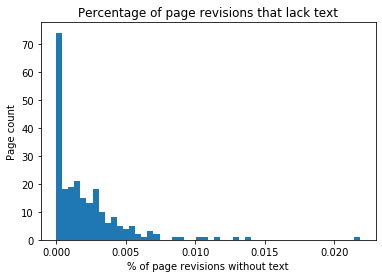

In [21]:
# distribution of pages by percentage of noText revisions
page_rev_pct_noText = page_rev_noText_counts / page_rev_doc_counts
plt.hist(page_rev_pct_noText, bins=50)
plt.title("Percentage of page revisions that lack text")
plt.xlabel("% of page revisions without text")
plt.ylabel("Page count")
plt.show()

In [22]:
total_pages_count, pages_with_reverts_count

(232, 230)

In [23]:
len(reverts)

150349

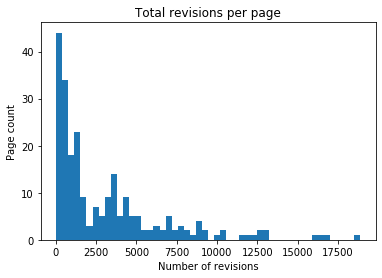

232

In [24]:
plt.hist(page_rev_doc_counts, bins=50)
plt.title("Total revisions per page")
plt.xlabel("Number of revisions")
plt.ylabel("Page count")
plt.show()
len(page_rev_doc_counts)

In [27]:
page_revert_counts = np.array([
        len(list(page_reverts)) for page, page_reverts in groupby(reverts, lambda revert: revert['reverting']['page']['id'])
    ])
assert len(page_revert_counts) == pages_with_reverts_count
len(page_revert_counts), len(page_rev_doc_counts)

(230, 232)

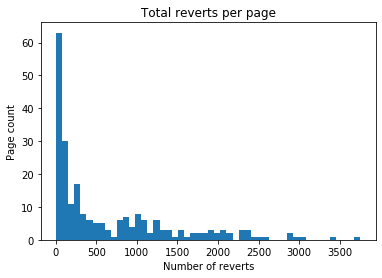

230

In [28]:
plt.hist(page_revert_counts, bins=50)
plt.title("Total reverts per page")
plt.xlabel("Number of reverts")
plt.ylabel("Page count")
plt.show()
len(page_revert_counts)

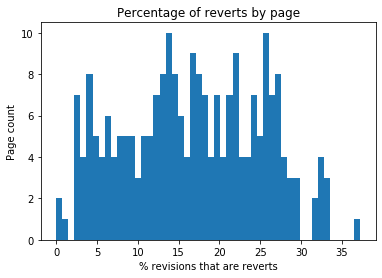

In [31]:
plt.hist(page_rev_revert_counts / page_rev_doc_counts * 100, bins=50, log=False)
plt.title("Percentage of reverts by page")
plt.xlabel("% revisions that are reverts")
plt.ylabel("Page count")
plt.show()

In [32]:
len(reverts)

150349

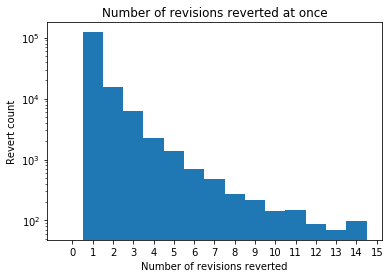

In [48]:
num_revs_reverted = np.array([len(revert['reverteds']) for revert in reverts])
assert np.all(num_revs_reverted > 0)
plt.hist(num_revs_reverted, bins=range(0,16), log=True, align='left')
plt.xticks(range(0, 16))
plt.title("Number of revisions reverted at once")
plt.xlabel("Number of revisions reverted")
plt.ylabel("Revert count")
plt.show()

In [50]:
# 18.3% of reverts role back multiple revisions
np.sum(num_revs_reverted > 1) / len(num_revs_reverted)

0.1829410238844289

In [67]:
reverts[0].keys()

dict_keys(['reverting', 'reverteds', 'reverted_to'])

In [68]:
reverts[0]['reverting'].keys()

dict_keys(['id', 'timestamp', 'user', 'page', 'minor', 'comment', 'text', 'sha1', 'parent_id', 'model', 'format', 'deleted'])

In [81]:
reverts[0]['reverting']['timestamp'],\
datetime.strptime(reverts[0]['reverting']['timestamp'], "%Y-%m-%dT%H:%M:%SZ")

('2002-04-02T09:54:12Z', datetime.datetime(2002, 4, 2, 9, 54, 12))

In [108]:
time_to_most_recent_reverted_list = []
is_multirevert_list = []
for page, page_reverts in groupby(reverts, lambda revert: revert['reverting']['page']['id']):
    page_reverts = list(page_reverts)
    #print(page_title_dict[page])
    #print(len(page_reverts))
    for revert in page_reverts:
        reverted_at_timestamp = int(datetime.strptime(revert['reverting']['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        reverted_to_timestamp = int(datetime.strptime(revert['reverted_to']['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())

        reverteds = sorted(revert['reverteds'], key=lambda r: (r.get('timestamp'), r.get('id')))
        is_multirevert = len(reverteds) > 1
        revert_timestamp = int(datetime.strptime(reverteds[-1]['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        time_to_most_recent_reverted = reverted_at_timestamp - revert_timestamp
        time_to_most_recent_reverted_list.append(time_to_most_recent_reverted)
        is_multirevert_list.append(is_multirevert)
        #for reverted_revert in revert['reverteds']:
        #    revert_timestamp = int(datetime.strptime(reverted_revert['timestamp'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        #    time_to_revert = reverted_at_timestamp - revert_timestamp
        #    assert time_to_revert >= time_to_most_recent_reverted, time_to_most_recent_reverted
        #    time_to_most_recent_reverted = time_to_revert
        #     assert time_to_revert >= 0, time_to_revert
        

In [109]:
np.sum(np.array(time_to_most_recent_reverted_list) <= 0) / len(time_to_most_recent_reverted_list)

0.00021283812995098072

In [116]:
# percent of reverts that occur after more than a day
np.sum(np.array(time_to_most_recent_reverted_list) >= 60 * 60 * 24) / len(time_to_most_recent_reverted_list)

0.017924961256809157

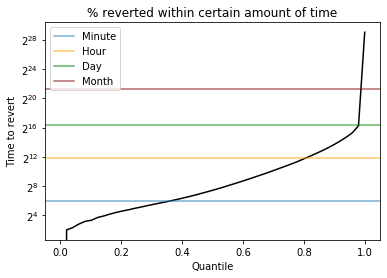

In [126]:
x = np.array(time_to_most_recent_reverted_list)
qs = np.linspace(0, 1)
ys = [np.quantile(x, q) for q in qs]
plt.plot(qs, ys, color='black')
plt.yscale('log', nonposy='clip', basey=2)

ax = plt.gca()
# add semantically interpretable time moments
ax.axhline(1 * 60, alpha=0.6, label='Minute')
ax.axhline(1 * 60 * 60, alpha=0.6, label='Hour', color='orange')
ax.axhline(1 * 60 * 60 * 24, alpha=0.6, label='Day', color='green')
ax.axhline(1 * 60 * 60 * 24 * 30, alpha=0.6, label='Month', color='maroon')

plt.legend()

plt.xlabel("Quantile")
plt.ylabel("Time to revert")
plt.title("% reverted within certain amount of time")

plt.show()

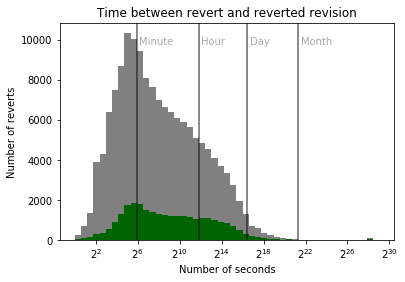

In [114]:
x = np.clip(np.array(time_to_most_recent_reverted_list), 1, None)
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='gray')
plt.hist(x[np.array(is_multirevert_list)], bins=logbins, color='darkgreen', label='Most recent of multi-reverted')
plt.xscale('log', nonposx='clip', basex=base)

ax = plt.gca()
# add semantically interpretable time moments
ax.axvline(1 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24 * 30, color='black', alpha=0.6)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.90))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1 * 60 * 1.2, text_y, 'Minute', color='darkgray')
ax.text(1 * 60 * 60 * 1.2, text_y, 'Hour', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 1.2, text_y, 'Day', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 30 * 1.2, text_y, 'Month', color='darkgray')

plt.title("Time between revert and reverted revision")
plt.xlabel("Number of seconds")
plt.ylabel("Number of reverts")

#plt.legend()

plt.show()

In [140]:
is_self_revert_list = []
is_multiuser_revert_list = []
unique_reverted_user_counts = []
no_reverting_user_count = 0
for page, page_reverts in groupby(reverts, lambda revert: revert['reverting']['page']['id']):
    page_reverts = list(page_reverts)
    for revert in page_reverts:
        if 'user' not in revert['reverting']:
            no_reverting_user_count += 1
            continue
        reverting_user = revert['reverting']['user']['text']
        reverted_users = set([revert['user']['text'] for revert in revert['reverteds'] if 'user' in revert])
        
        is_self_revert = reverting_user in reverted_users
        is_self_revert_list.append(is_self_revert)
        is_multiuser_revert = len(reverted_users) > 1
        is_multiuser_revert_list.append(is_multiuser_revert)
        unique_reverted_user_counts.append(len(reverted_users))
            
is_self_revert_list = np.array(is_self_revert_list)
is_multiuser_revert_list = np.array(is_multiuser_revert_list)
unique_reverted_user_counts = np.array(unique_reverted_user_counts)
no_reverting_user_count

1

In [137]:
# 7% of reverts revert the users own work
np.sum(is_self_revert_list), np.sum(is_self_revert_list) / len(is_self_revert_list)

(10359, 0.06890015164817623)

In [146]:
# 6% of reverts have multiple reverted users
np.sum(is_multiuser_revert_list) / len(is_multiuser_revert_list)

0.05884348311916354

In [139]:
# 28% of multi-user reverts involve the self
np.sum(is_self_revert_list&is_multiuser_revert_list) / np.sum(is_multiuser_revert_list)

0.2803210127726913

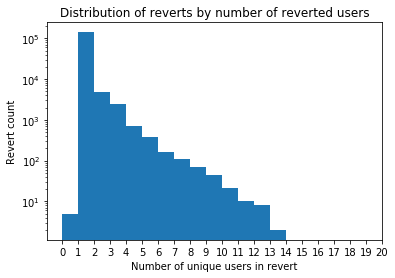

In [145]:
plt.hist(unique_reverted_user_counts, bins=range(0, 20), log=True)
plt.xticks(range(0, 21))
plt.title("Distribution of reverts by number of reverted users")
plt.xlabel("Number of unique users in revert")
plt.ylabel("Revert count")
plt.show()

### Examination of the edit distance of reverts

And the correlation between edit distance and speed of revert

### Test extraction of revision info from dump file

In [33]:
page_rev_doc_counts = []
dump = mwxml.Dump.from_file(bz2.open(dump_filepath, 'rt'))
c = 0
for page in dump:
    if page.namespace == 0 and page.redirect is None:
        c+=1
        revs = [rev for rev in page]
        assert len(revs) == 1
        rev = revs[-1]
        rev_json = rev.to_json()
        print(rev_json.keys())
        for key in rev_json.keys():
            if key == 'text':
                continue
            print(key, ":::", rev_json[key])
        print()
    if c > 3:
        break

dict_keys(['id', 'timestamp', 'user', 'page', 'minor', 'comment', 'text', 'sha1', 'parent_id', 'model', 'format', 'deleted'])
id ::: 920223784
timestamp ::: 2019-10-08T11:27:20Z
user ::: {'id': 23085006, 'text': 'Rubbish computer'}
page ::: {'id': 12, 'title': 'Anarchism', 'namespace': 0, 'restrictions': []}
minor ::: True
comment ::: Reverted edits by [[Special:Contributions/194.168.162.21|194.168.162.21]] ([[User talk:194.168.162.21|talk]]): [[WP:SANDBOX|editing tests]] ([[WP:HG|HG]]) (3.4.9)
sha1 ::: owe1w0l4rmdrhp2w7cji3zazxklru08
parent_id ::: 920223323
model ::: wikitext
format ::: text/x-wiki
deleted ::: {'text': False, 'comment': False, 'user': False}

dict_keys(['id', 'timestamp', 'user', 'page', 'minor', 'comment', 'text', 'sha1', 'parent_id', 'model', 'format', 'deleted'])
id ::: 922132190
timestamp ::: 2019-10-20T04:34:06Z
user ::: {'id': 3810835, 'text': 'Doc James'}
page ::: {'id': 25, 'title': 'Autism', 'namespace': 0, 'restrictions': []}
minor ::: False
comment ::: not 